# Kernel SVM
Your task is to implement linear SVM, kernel SVM, and soft margin SVM from scratch. You can use the libraries imported in the cell below. You are **NOT** allowed to use other libraries.

In [ ]:
!pip install "qpsolvers[open_source_solvers]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.5/594.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.5/166.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import qpsolvers

In [ ]:
torch.manual_seed(0)
def gen_data(
    mu_pos = torch.FloatTensor([2.5, 2.5]),
    mu_neg = torch.FloatTensor([-2.5, -2.5]),
    Sigma_pos = torch.FloatTensor([[2, 0.3], [0.5, 1]]),
    Sigma_neg = torch.FloatTensor([[2, 0.3], [0.5, 1]]),
    n = 100
  ):
  class_pos = torch.randn(size=(n, 2)) @ Sigma_pos + mu_pos
  class_neg = torch.randn(size=(n, 2)) @ Sigma_neg + mu_neg
  return class_pos, class_neg

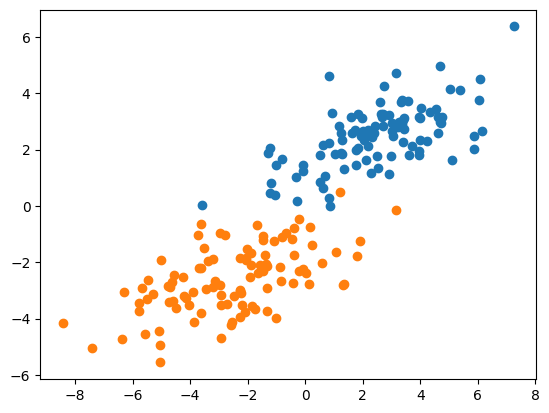

In [ ]:
class_pos, class_neg = gen_data()
label_pos, label_neg = torch.ones(class_pos.shape[0], 1), 0 - torch.ones(class_neg.shape[0], 1)
train_label = torch.cat([label_pos, label_neg], dim=0)
train_input = torch.cat([class_pos, class_neg], dim=0)
train_data = torch.cat([train_input, train_label], dim=1)

plt.scatter(train_data[train_data[:, 2] == 1, 0], train_data[train_data[:, 2] == 1, 1])
plt.scatter(class_neg[:, 0], class_neg[:, 1])
plt.show()

In [ ]:
class SVM:
  def __init__(self, kernel, C):
    """
    @param kernel: kernel function, could be 'linear', 'poly', 'rbf', or your own.
    Note that rbf kernel is also called Gaussian kernel.
    @param C: regularization parameter for soft-margin SVM, see lecture slide
    """
    self.kernel = kernel
    self.C = C
    self.support_vectors = []
    self.support_labels = []
    self.alpha = []
    self.b = 0

  def kernel_function(self, x ,y):
    if self.kernel == 'linear':
      return np.dot(x, y)
    elif self.kernel == 'poly':
      degree = 3
      return (np.dot(x, y) + 1) ** degree
    elif self.kernel == 'rbf':
      sigma = 1.0
      diff = x - y
      return np.exp(-np.dot(diff, diff) / (2 * sigma ** 2))
    else:
      raise ValueError("Unknown kernel")

  def train(self, train_data):
    """
    train_data: a list of (x, y) pairs, where x is a data point and y is a label
    """
    # Your code here
    # you should store the support vectors in self.support_vectors
    train_data = np.array(train_data)
    X = train_data[:, :2]
    y = train_data[:, 2]
    n_samples = X.shape[0]

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = y[i] * y[j] * self.kernel_function(X[i], X[j])

    P = K
    q = -np.ones(n_samples)
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples)))
    A = y.reshape(1, -1)
    b = np.array([0.])

    alpha = qpsolvers.solve_qp(P, q, G, h, A, b, solver='osqp')

    sv = alpha > 1e-5
    self.alpha = alpha[sv]
    self.support_vectors = X[sv]
    self.support_labels = y[sv]

    b_sum = 0
    for i in range(len(self.alpha)):
      s = 0
      for j in range(len(self.alpha)):
        s += self.alpha[j] * self.support_labels[j] * self.kernel_function(self.support_vectors[j], self.support_vectors[i])
      b_sum += self.support_labels[i] - s
    self.b = b_sum / len(self.alpha) if len(self.alpha) > 0 else 0

  def infer(self, data):
    """
    data: a list of data points
    return: a list of predictions
    """
    # Your code here
    data = np.array(data)
    y_pred = []
    for x in data:
        s = 0
        for alpha, sv_y, sv_x in zip(self.alpha, self.support_labels, self.support_vectors):
            s += alpha * sv_y * self.kernel_function(sv_x, x)
        s += self.b
        y_pred.append(1 if s > 0 else -1)
    return np.array(y_pred)

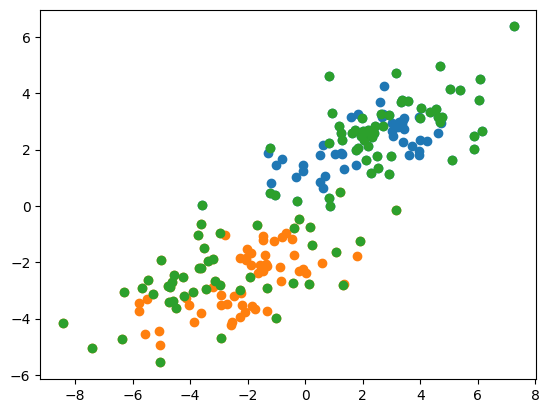

In [ ]:
# svm = SVM(kernel='linear', C=np.inf) # linear, hard margin SVM
svm = SVM(kernel='rbf', C=1) # rbf, soft margin SVM
svm.train(train_data)

# visualize
plt.scatter(train_data[train_data[:, 2] == 1, 0], train_data[train_data[:, 2] == 1, 1])
plt.scatter(train_data[train_data[:, 2] == -1, 0], train_data[train_data[:, 2] == -1, 1])
plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1])
plt.show()

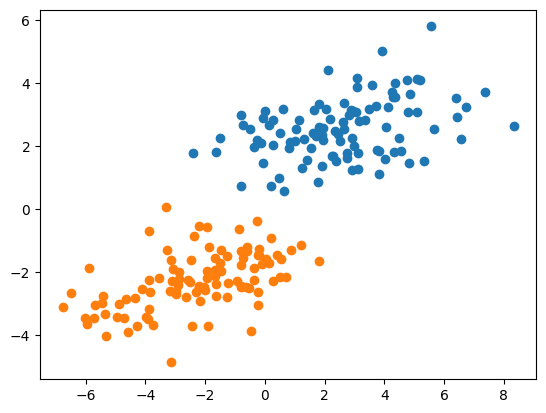

In [ ]:
test_pos, test_neg = gen_data(n=100)
data = torch.cat([test_pos, test_neg])

labels = svm.infer(data)

# visualize
plt.scatter(data[labels == 1, 0], data[labels == 1, 1])
plt.scatter(data[labels == -1, 0], data[labels == -1, 1])
plt.show()